In [451]:
# %pip install scikit-learn
# %pip install nba_api pandas requests numpy

In [ ]:
# constants and functions
import time
import random
import itertools
import numpy as np
import pandas as pd
from math import pi
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rules = {
    "pts": 1, 
    "reb": 1.2, 
    "ast": 1.5, 
    "stl": 3, 
    "blk": 3, 
    "tov": 1 
}

ROSTER_LIMITS = {
    'C': 2,
    'PF': 2, 
    'SF': 2, 
    'SG': 2, 
    'PG': 2
}

POS_MAPPING = {
    'C':   ['C'],
    'F':   ['SF', 'PF'],
    'G':   ['PG', 'SG'],
    'G-F': ['PG', 'SG', 'SF', 'PF'],
    'F-G': ['PG', 'SG', 'SF', 'PF'],
    'F-C': ['SF', 'PF', 'C'],
    'C-F': ['SF', 'PF', 'C']
}

# feature_engineering.py
def load_data_by_filename(filename):
    df = pd.read_csv(filename)
    df.columns = [c.lower() for c in df.columns]
    
    # 欄位對應修正
    rename_map = {'gp_base': 'gp', 'age_base': 'age', 'min_base': 'min'}
    df = df.rename(columns=rename_map)
    
    # 篩選球隊
    NBA_TEAMS = {
        "ATL","BOS","BKN","CHA","CHI","CLE","DAL","DEN","DET",
        "GSW","HOU","IND","LAC","LAL","MEM","MIA","MIL","MIN",
        "NOP","NYK","OKC","ORL","PHI","PHX","POR","SAC","SAS",
        "TOR","UTA","WAS"
    }
    if 'team_abbreviation' in df.columns:
        df = df[df['team_abbreviation'].isin(NBA_TEAMS)].copy()
    
    # 位置處理
    if 'position' in df.columns:
        df.loc[df['position'] == '0', 'position'] = 'G-F'
    else:
        df['position'] = 'G-F' # 防呆

    # 計算 Fantasy Score (真實答案)
    rules = {'pts': 1, 'reb': 1.2, 'ast': 1.5, 'stl': 3, 'blk': 3, 'tov': 1}
    df['fantasy_score'] = (
        df['pts'] * rules['pts'] +
        df['reb'] * rules['reb'] +
        df['ast'] * rules['ast'] +
        df['stl'] * rules['stl'] +
        df['blk'] * rules['blk'] -
        df['tov'] * rules['tov']
    )
    
    return df

def compute_fantasy_score(df, rules):
    """
    根據規則計算 Fantasy Score。
    """
    df['fantasy_score'] = (
        df['pts'] * rules.get('pts', 1) +
        df['reb'] * rules.get('reb', 1.2) +
        df['ast'] * rules.get('ast', 1.5) +
        df['stl'] * rules.get('stl', 3) +
        df['blk'] * rules.get('blk', 3) -
        df['tov'] * rules.get('tov', 1) # 注意失誤通常是扣分，這裡假設傳進來是正數，運算時減去
    )
    return df

def create_ml_features(df):
    """
    準備訓練資料，並計算 '耐戰度' 指標
    """
    # 1. 確保有 GP 欄位 (上面的 rename 應該已經解決了這個問題)
    if 'gp' not in df.columns:
        print("警告：找不到 'gp' 欄位，預設為全勤 (82場)")
        df['gp'] = 82
        
    # 2. 計算耐戰度係數 (Durability Factor)
    # 優化：有些資料 GP 上限可能只有 80，我們用該資料集的最大值來標準化
    max_gp = df['gp'].max()
    if max_gp == 0: max_gp = 82
    
    # 公式：(出賽場次 / 最大場次)^2
    df['durability_score'] = (df['gp'] / max_gp) ** 2
    
    # 3. 定義題目 (X)
    feature_columns = ['pts', 'reb', 'ast', 'stl', 'blk', 'tov']
    X = df[feature_columns].fillna(0)
    
    # 4. 定義答案 (y)
    y = df['fantasy_score']
    
    return X, y

# ml_models.py
def train_draft_model(X, y):
    """
    訓練 AI 模型。
    輸入 X: 球員數據
    輸入 y: 真實分數
    回傳: 訓練好的模型 (model)
    """
    print("⏳ 正在訓練 AI 模型，請稍候...")

    # 1. 建立模型
    # n_estimators=100 代表我們請 100 顆決策樹來幫忙判斷
    # random_state=42 是為了確保每次跑結果都一樣（方便除錯）
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # 2. 訓練模型 (Fit)
    # 這行程式碼就是在讓電腦「讀書」，學習 X 和 y 之間的關係
    model.fit(X, y)

    print("模型訓練完成！")
    
    return model

# ai_agent.py

def get_eligible_slots(raw_pos):
    """
    輸入 CSV 的位置字串 (如 'G-F')，回傳它可以填的所有坑 (如 ['PG', 'SG', 'SF', 'PF'])
    """
    # 移除可能存在的空格
    raw_pos = raw_pos.replace(" ", "").upper()
    
    # 直接查表，查不到就回傳空 (或是預設 G-F 增加容錯)
    return POS_MAPPING.get(raw_pos, [])

def count_open_slots(current_team_df):
    """
    【核心演算法】計算目前隊伍還剩哪些空位，為動態分配雙位置球員。
    """
    if current_team_df.empty:
        # 如果隊伍是空的，所有位置都缺 2 人
        return ROSTER_LIMITS.copy()

    # 1. 初始化剩餘空位 (複製一份 LIMITS)
    remaining_slots = ROSTER_LIMITS.copy()
    
    # 2. 取得目前隊員的位置屬性，並計算「靈活度」
    # 靈活度低 (只能打1個位置) 的人要先入座
    roster_data = []
    
    # 假設 CSV 位置欄位叫 'position'
    pos_col = 'position' if 'position' in current_team_df.columns else 'pos'
    
    for _, player in current_team_df.iterrows():
        raw_pos = str(player[pos_col])
        eligible = get_eligible_slots(raw_pos)
        # 存成 (靈活度, 可選位置列表, 球員名字)
        # 靈活度越小 (len 越小)，排序越前面，優先被分配
        roster_data.append((len(eligible), eligible, player.get('player_name', 'Unknown')))
        
    # 3. 排序：先排死板的人 (純C)，再排靈活的人 (G-F)
    roster_data.sort(key=lambda x: x[0])
    
    # 4. 開始填坑 (Greedy Assignment)
    for _, eligible_slots, name in roster_data:
        assigned = False
        # 嘗試把這個球員塞進他能打的、且還有空位的坑
        for slot in eligible_slots:
            if remaining_slots.get(slot, 0) > 0:
                remaining_slots[slot] -= 1 # 佔用一個位置
                assigned = True
                break # 塞進去了，換下一個球員
        
        # 如果 assigned 為 False，代表這個球員想打的位置都滿了
        # (理論上 AI 邏輯寫得好不該發生，但發生了也沒關係，就當作溢出名單)
            
    return remaining_slots

def filter_valid_positions(available_df, current_team_df):
    """
    根據「剩餘空位」來過濾候選名單
    """
    if current_team_df.empty:
        return available_df.copy()
        
    # 1. 算出目前到底缺什麼位置 (最精華的一步)
    open_slots_dict = count_open_slots(current_team_df)
    
    # 找出剩餘名額 > 0 的坑 (例如 ['C', 'PG'])
    needed_slots = [slot for slot, count in open_slots_dict.items() if count > 0]
    
    # 如果全滿了 (雖然不太可能)，回傳空
    if not needed_slots:
        print("⚠️ 隊伍已滿，無法再選！")
        return pd.DataFrame() # 空的 DataFrame
    
    # 2. 篩選：只要球員能打的任何一個位置在 needed_slots 裡，就保留
    # 這裡比較慢一點點，因為要逐行掃描，但幾百人沒差
    
    pos_col = 'position' if 'position' in available_df.columns else 'pos'
    
    # 定義一個 apply 函式來判斷
    def is_valid(raw_pos):
        player_can_play = get_eligible_slots(str(raw_pos))
        # 取交集：球員能打的位置 AND 隊伍缺的位置
        # 如果交集不是空集合，代表有坑可填
        return bool(set(player_can_play) & set(needed_slots))
        
    mask = available_df[pos_col].apply(is_valid)
    
    filtered_df = available_df[mask].copy()
    
    # 防呆：如果篩到沒人 (極端狀況)，回傳原名單避免崩潰
    if filtered_df.empty:
        return available_df.copy()
        
    return filtered_df

def predict_players(available_df, model):
    """基礎預測"""
    # 確保操作的是複本，不影響原始資料
    df = available_df.copy()
    
    feature_columns = ['pts', 'reb', 'ast', 'stl', 'blk', 'tov']
    # 這裡也要用 copy 避免隱式警告
    X_current = df[feature_columns].fillna(0).copy()
    
    df['pred_score'] = model.predict(X_current)
    return df

# --- Easy AI (隨機 + 位置限制) ---
def ai_pick_easy(available_df, model, current_team_df):
    # 1. 先濾掉位置滿的人 (現在這裡會回傳乾淨的 copy)
    candidates = filter_valid_positions(available_df, current_team_df)
    
    # 2. 預測
    candidates = predict_players(candidates, model)
    
    # 3. 隨機選前 20 強
    top_n = candidates.nlargest(20, 'pred_score')
    return random.choice(top_n.index.tolist())

# --- Medium AI (貪婪 + 耐戰度 + 位置限制) ---
def ai_pick_medium(available_df, model, current_team_df):
    # 1. 濾位置
    candidates = filter_valid_positions(available_df, current_team_df)
    candidates = predict_players(candidates, model)
    
    # 2. 加入「耐戰度」考量
    # 因為 candidates 已經是 copy 了，這裡可以放心修改
    candidates['final_score'] = candidates['pred_score'] * candidates['durability_score']
    
    return candidates['final_score'].idxmax()

# --- Hard AI (動態補強 + 位置限制 + 耐戰度) ---
def ai_pick_hard(available_df, model, current_team_df):
    """
    加入「邊際效益遞減」邏輯：當某項數據已經強到穩贏時，就不再刻意追求，轉而補強弱項。
    """
    # 1. 濾位置
    candidates = filter_valid_positions(available_df, current_team_df)
    candidates = predict_players(candidates, model)
    
    # 2. 設定基礎權重 (Roto 標準)
    # 預設權重不用太激進，保持微幅加權即可
    weights = {'pts': 1, 'reb': 1.2, 'ast': 1.5, 'stl': 2, 'blk': 2, 'tov': -1}
    
    # 3. 【動態補強邏輯：邊際效益遞減】
    if not current_team_df.empty:
        avg_stats = current_team_df[['pts', 'reb', 'ast', 'stl', 'blk']].mean()
        
        # 設定「穩贏閾值」 (Saturation Point)
        # 如果隊伍平均達到這個數字，代表該項目已經很強，不用再補了
        saturation_targets = {'ast': 8.0, 'blk': 1.5, 'stl': 1.8, 'reb': 10.0}
        
        # 設定「及格線」 (Minimum Requirement)
        # 如果低於這個數字，代表是弱項，要瘋狂補強
        min_targets = {'ast': 4.0, 'blk': 0.8, 'stl': 1.0, 'reb': 5.0}
        
        for cat in ['ast', 'blk', 'stl', 'reb']:
            current_val = avg_stats.get(cat, 0)
            
            if current_val > saturation_targets[cat]:
                # 已經太強了，降低權重 (回歸正常或甚至低於正常)，去選別的
                weights[cat] = 0.5 
                # print(f"(Debug) {cat} 已達標 ({current_val:.1f})，降低權重...")
                
            elif current_val < min_targets[cat]:
                # 還是弱項，瘋狂加權
                weights[cat] = 5.0
                # print(f"(Debug) {cat} 不足 ({current_val:.1f})，緊急補強！")
            
            else:
                # 在中間值，維持稍微重視
                weights[cat] = 2.0

    # 4. 計算動態分數
    # 這裡使用「加法邏輯」而不是乘法，避免權重過大導致數值失控
    # 我們算出各單項的「加權貢獻值」
    
    candidates['dynamic_score'] = (
        candidates['pred_score'] + # 基礎盤
        (candidates['pts'] * 0.5) + # 得分還是要顧，給一點基本分
        (candidates['reb'] * (weights['reb'] - 1.2)) +
        (candidates['ast'] * (weights['ast'] - 1.5)) +
        (candidates['stl'] * (weights['stl'] - 2)) * 10 + # 放大稀有數據的影響力
        (candidates['blk'] * (weights['blk'] - 2)) * 10
    )
    
    # 5. 耐戰度乘數 (這是 Hard AI 的根基)
    candidates['dynamic_score'] *= candidates['durability_score']
    
    return candidates['dynamic_score'].idxmax()

# --- Grandmaster AI (動態 Z-Score 估值法) ---
def ai_pick_grandmaster(available_df, model, current_team_df, opponent_teams_dfs=None):
    """
    參數:
    - available_df: 當前可選球員名單
    - model: 預測模型
    - current_team_df: AI 自己的隊伍 (用於補強)
    - opponent_teams_dfs: 對手的隊伍 (用於攔截)，可以是單一 DataFrame 或 DataFrame 列表
    """
    
    # --- 內部核心：計算某球員對某支隊伍的價值 (GM Score) ---
    def _calc_score(candidates_df, target_team_df):
        # 1. 計算 Z-Score (統計學估值)
        categories = ['pts', 'reb', 'ast', 'stl', 'blk', 'tov']
        
        # 以剩餘池中的 Top 100 為基準，計算平均與標準差
        top_pool = candidates_df.nlargest(100, 'pred_score')
        means = top_pool[categories].mean()
        stds = top_pool[categories].std().replace(0, 1) # 避免除以 0

        z_scores = pd.DataFrame()
        for cat in categories:
            if cat == 'tov':
                # 失誤越少越好
                z_scores[cat] = (means[cat] - candidates_df[cat]) / stds[cat]
            else:
                z_scores[cat] = (candidates_df[cat] - means[cat]) / stds[cat]

        # 2. 設定動態權重 (Dynamic Weights)
        # 基礎權重
        weights = {'pts': 0.8, 'reb': 0.9, 'ast': 1.0, 'stl': 1.2, 'blk': 1.2, 'tov': 0.8}
        
        # 根據隊伍現況調整權重 (邊際效益遞減)
        if not target_team_df.empty:
            avg_stats = target_team_df[categories].mean()
            # 飽和點 (太強了，不用再補)
            saturation = {'ast': 8.0, 'blk': 1.8, 'stl': 2.0, 'reb': 12.0}
            # 飢渴點 (太弱了，急需補強)
            hunger = {'ast': 4.0, 'blk': 0.8, 'stl': 1.0, 'reb': 6.0}
            
            for cat in ['ast', 'blk', 'stl', 'reb']:
                val = avg_stats.get(cat, 0)
                if val > saturation.get(cat, 99):
                    weights[cat] *= 0.5 
                elif val < hunger.get(cat, 0):
                    weights[cat] *= 3.0 

        # 3. 加權總分
        candidates_df['gm_score'] = 0
        for cat in categories:
            candidates_df['gm_score'] += z_scores[cat] * weights[cat]
            
        # 4. 耐戰度修正 (健康第一)
        candidates_df['gm_score'] *= candidates_df['durability_score']
        
        return candidates_df

    # ==========================================
    # 主決策邏輯
    # ==========================================
    
    # 1. 【自我評估】找出對我最有利的人選
    my_candidates = filter_valid_positions(available_df, current_team_df)
    
    # 極端防呆：如果沒人可選，回傳最高分者
    if my_candidates.empty:
        return available_df['pred_score'].idxmax()

    my_candidates = predict_players(my_candidates, model)
    my_candidates = _calc_score(my_candidates, current_team_df)
    
    my_best_id = my_candidates['gm_score'].idxmax()
    my_best_val = my_candidates.loc[my_best_id, 'gm_score']

    # 2. 【惡意攔截 (Hate Draft)】掃描所有對手
    
    # 統一將輸入轉為列表 (支援單一對手或多對手)
    opponents_list = []
    if opponent_teams_dfs is not None:
        if isinstance(opponent_teams_dfs, list):
            opponents_list = opponent_teams_dfs
        elif not opponent_teams_dfs.empty:
            opponents_list = [opponent_teams_dfs]
            
    best_block_target_id = None
    max_threat_val = -1
    
    # 遍歷每一個對手，看誰最需要被攔截
    for opp_team in opponents_list:
        if opp_team.empty: continue
            
        # 模擬該對手的視角 (注意：要用對手的 current_team 來過濾位置)
        opp_candidates = filter_valid_positions(available_df, opp_team)
        
        if not opp_candidates.empty:
            opp_candidates = predict_players(opp_candidates, model)
            # 計算該球員對「這個對手」的價值
            opp_candidates = _calc_score(opp_candidates, opp_team)
            
            curr_opp_best_id = opp_candidates['gm_score'].idxmax()
            curr_opp_best_val = opp_candidates.loc[curr_opp_best_id, 'gm_score']
            
            # 如果這個人對某個對手的價值，比目前紀錄的威脅還大，更新攔截目標
            if curr_opp_best_val > max_threat_val:
                max_threat_val = curr_opp_best_val
                best_block_target_id = curr_opp_best_id

    # 3. 【最終決策】比較「利己」與「損人」
    
    # 惡意係數 (Malice Factor): 
    # 設定為 1.4 代表：除非對手的收益大於我的 1.4 倍，否則我還是優先顧自己
    # 如果設為 1.0，AI 會變成瘋狗，只要對手爽度比我高一點點就會攔截
    malice_factor = 1.4
    
    # 條件：
    # (1) 找到了攔截目標
    # (2) 對手的收益 > 我的收益 * 係數
    # (3) 重要：我也「能」選這個人 (必須在我的 candidates 名單內，位置符合)
    if (best_block_target_id is not None) and \
       (max_threat_val > my_best_val * malice_factor) and \
       (best_block_target_id in my_candidates.index):
        
        # print(f"😈 Grandmaster 進行攔截！搶走 {available_df.loc[best_block_target_id, 'player_name']}")
        return best_block_target_id

    # 沒觸發攔截，回傳對自己最好的
    return my_best_id

In [ ]:
#模擬AI選秀
def simulate_ai_draft(difficulty, df, model, rounds=10):
    """
    模擬特定難度的 AI 進行選秀
    """
    available = df.copy()
    my_team_ids = []
    
    for _ in range(rounds):
        # 取得目前已選的隊伍 (DataFrame 格式)
        current_team = df.loc[my_team_ids] if my_team_ids else pd.DataFrame(columns=df.columns)
        
        # 呼叫 AI (現在多了一個參數 current_team)
        if difficulty == "easy":
            pick = ai_pick_easy(available, model, current_team)
        elif difficulty == "medium":
            pick = ai_pick_medium(available, model, current_team)
        elif difficulty == "hard":
            pick = ai_pick_hard(available, model, current_team)
        elif difficulty == "grandmaster":
            pick = ai_pick_grandmaster(available, model, current_team)
            
        my_team_ids.append(pick)
        available = available.drop(pick)
    
    return df.loc[my_team_ids]

#繪製雷達圖
def plot_ai_radar_chart(teams_dict):
    """
    繪製 AI 隊伍實力比較雷達圖
    teams_dict: 字典格式，例如 {'Easy': team_easy, 'Medium': team_medium, ...}
    """
    # 1. 設定要比較的數據項目
    categories = ['PTS', 'REB', 'AST', 'STL', 'BLK']
    col_map = {'PTS': 'pts', 'REB': 'reb', 'AST': 'ast', 'STL': 'stl', 'BLK': 'blk'}
    
    # 2. 計算各隊平均數據
    data = {}
    for name, df in teams_dict.items():
        stats = [df[col_map[c]].mean() for c in categories]
        data[name] = stats
        
    # 3. 數據標準化 (Normalization)
    # 因為得分(20分)跟火鍋(1個) 單位差太多，必須正規化到 0~1 之間才能畫在一起
    # 我們找出每個項目的「最大值」，然後大家除以最大值
    max_vals = [0] * len(categories)
    for stats in data.values():
        for i, val in enumerate(stats):
            if val > max_vals[i]:
                max_vals[i] = val
    
    # 避免除以 0
    max_vals = [v if v > 0 else 1 for v in max_vals]
    
    data_norm = {}
    for name, stats in data.items():
        data_norm[name] = [s / m for s, m in zip(stats, max_vals)]
        
    # 4. 開始繪圖
    N = len(categories)
    # 計算角度 (把圓周分成 N 等份)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # 讓線條閉合回去
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True) # 設定為極座標 (圓形)
    
    # 設定 X 軸標籤 (PTS, REB...)
    plt.xticks(angles[:-1], categories, color='black', size=12)
    
    # 設定 Y 軸刻度 (25%, 50%, 75%)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=8)
    plt.ylim(0, 1)
    
    # 設定顏色
    colors = {'Easy AI': 'blue', 'Medium AI': 'orange', 'Hard AI': 'red'}
    
    # 畫出每一隊
    for name, stats_norm in data_norm.items():
        values = stats_norm
        values += values[:1] # 閉合
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=name, color=colors.get(name, 'black'))
        ax.fill(angles, values, color=colors.get(name, 'black'), alpha=0.1) # 填充顏色
        
    plt.title('AI Team Strength Comparison', size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()
    
def get_game_performance(avg_val, variance_factor=0.25):
    """
    模擬單場比賽表現
    avg_val: 球員該項數據的賽季平均
    variance_factor: 波動程度 (0.25 代表標準差是平均的 25%)
    """
    if avg_val <= 0: return 0
    
    # 計算標準差
    std_dev = avg_val * variance_factor
    
    # 從常態分佈抽樣 (模擬忽好忽壞)
    actual_val = np.random.normal(avg_val, std_dev)
    
    # 數據不能是負的
    return max(0, actual_val)

def simulate_match_with_variance(player_team_df, ai_team_df, match_count=1):
    """
    模擬比賽 (加入波動性)
    match_count: 模擬幾場 (Roto 通常是一季，這裡我們先模擬一場定勝負，或者多場累計)
    """
    categories = ['pts', 'reb', 'ast', 'stl', 'blk', 'tov']
    
    # 定義不同數據的波動程度
    # 得分、籃板比較穩 (0.25)
    # 抄截、火鍋很看運氣 (0.5)
    # 失誤也很不穩 (0.4)
    variance_map = {
        'pts': 0.25, 'reb': 0.25, 'ast': 0.3,
        'stl': 0.5,  'blk': 0.5,  'tov': 0.4
    }
    
    player_wins = 0
    ai_wins = 0
    
    #print(f"\n=== 🏀 比賽模擬開始 (加入波動性) ===")
    
    # 儲存雙方總數據 (用於最後比較)
    player_totals = {cat: 0.0 for cat in categories}
    ai_totals = {cat: 0.0 for cat in categories}
    
    # 針對隊伍裡的每一個球員，模擬他們的單場表現
    for _ in range(match_count):
        # --- 玩家隊伍表現 ---
        for _, player in player_team_df.iterrows():
            for cat in categories:
                # 取得該球員該項目的波動表現
                val = get_game_performance(player[cat], variance_map[cat])
                player_totals[cat] += val

        # --- AI 隊伍表現 ---
        for _, ai_player in ai_team_df.iterrows():
            for cat in categories:
                val = get_game_performance(ai_player[cat], variance_map[cat])
                ai_totals[cat] += val
    
    # --- 結算比分 ---
    print(f"{'Category':<10} | {'Player':<10} | {'AI':<10} | {'Winner'}")
    print("-" * 45)
    
    for cat in categories:
        p_score = player_totals[cat]
        a_score = ai_totals[cat]
        
        # 判斷該項目誰贏
        if cat == 'tov': # 失誤越少越好
            if p_score < a_score:
                cat_winner = "Player"
                player_wins += 1
            else:
                cat_winner = "AI"
                ai_wins += 1
        else: # 其他數據越高越好
            if p_score > a_score:
                cat_winner = "Player"
                player_wins += 1
            else:
                cat_winner = "AI"
                ai_wins += 1
                
        print(f"{cat.upper():<10} | {p_score:<10.1f} | {a_score:<10.1f} | {cat_winner}")
    
    print("-" * 45)
    print(f"🏆 最終比數: Player {player_wins} - {ai_wins} AI")
    
    if player_wins > ai_wins:
        print("🎉恭喜！你贏了！")
        return "Player"
    elif ai_wins > player_wins:
        print("💀 你輸了...")
        return "AI"
    else:
        print("🤝 平手！")
        return "Draw"
    
#AI顧問
def draft_phase_interactive(df, model, difficulty="medium"):
    """
    互動式選秀主程式：包含 AI 顧問功能
    """
    available = df.copy()
    
    # 兩隊名單
    player_team_ids = []
    ai_team_ids = []
    
    rounds = 10 # 設定選秀輪次
    
    print(f"\n========== 🏀 Fantasy 選秀開始 (難度: {difficulty}) ==========\n")
    
    for r in range(rounds):
        print(f"--- 第 {r+1} 輪 ---")
        
        # ==========================================
        # 🟢 1. 人類玩家回合 (附帶 AI 顧問)
        # ==========================================
        
        # 建立目前玩家隊伍的 DataFrame (給顧問分析用)
        current_player_team = df.loc[player_team_ids] if player_team_ids else pd.DataFrame(columns=df.columns)
        
        # --- 呼叫 AI 顧問 (借用 Hard AI 的腦袋) ---
        # 我們假裝 Hard AI 是你的軍師，幫你挑最好的
        suggested_id = ai_pick_hard(available, model, current_player_team)
        suggested_player = available.loc[suggested_id]
        
        # 分析為什麼推薦他 (找出他最強的數據)
        stats = suggested_player[['pts', 'reb', 'ast', 'stl', 'blk']]
        best_stat = stats.idxmax()
        best_val = stats.max()
        
        print(f"💡 [AI 顧問建議]: 根據你的隊形，推薦選擇 **{suggested_player['player_name']}**")
        print(f"   👉 理由: 他的 {best_stat.upper()} 高達 {best_val:.1f}，且耐戰度 {suggested_player['durability_score']:.2f}")
        
        # --- 玩家輸入選擇 ---
        while True:
            try:
                # 這裡為了測試方便，允許輸入 'auto' 直接採用建議
                user_input = input("請輸入球員 ID (或輸入 'auto' 採用建議): ")
                
                if user_input.lower() == 'auto':
                    pick_id = suggested_id
                else:
                    pick_id = int(user_input)
                
                if pick_id in available.index:
                    player_team_ids.append(pick_id)
                    player_name = available.loc[pick_id, 'player_name']
                    print(f"✅ 你選擇了: {player_name}\n")
                    available = available.drop(pick_id)
                    break
                else:
                    print("❌ 此 ID 不在可選名單中，請重試。")
            except ValueError:
                print("❌ 輸入錯誤，請輸入整數 ID。")

        # ==========================================
        # 🔴 2. AI 對手回合
        # ==========================================
        print(f"🤖 AI ({difficulty}) 思考中...", end="\r")
        time.sleep(1) # 假裝思考增加緊張感
        
        # 建立目前 AI 隊伍
        current_ai_team = df.loc[ai_team_ids] if ai_team_ids else pd.DataFrame(columns=df.columns)
        
        if difficulty == "easy":
            ai_pick = ai_pick_easy(available, model, curr_ai_team)
        elif difficulty == "medium":
            ai_pick = ai_pick_medium(available, model, curr_ai_team)
        elif difficulty == "hard":
            ai_pick = ai_pick_hard(available, model, curr_ai_team)
        elif difficulty == "grandmaster":
            ai_pick = ai_pick_grandmaster(available, model, curr_ai_team, opponent_teams_dfs=[curr_p_team])
        else:
            # 防呆預設
            ai_pick = ai_pick_medium(available, model, curr_ai_team)
            
        ai_team_ids.append(ai_pick)
        ai_player_name = available.loc[ai_pick, 'player_name']
        print(f"🤖 AI 選擇了: {ai_player_name}")
        available = available.drop(ai_pick)
        
        print("-" * 50)

    return df.loc[player_team_ids], df.loc[ai_team_ids]

In [453]:
# snake draft
# 輔助函式：顯示可選球員名單
def print_top_candidates(available_df, top_n=20):
    print(f"\n可選球員 Top {top_n}：")
    candidates = available_df.nlargest(top_n, 'pred_score')
    for idx, row in candidates.iterrows():
        print(f"{idx}. {row['player_name']} ({row['team_abbreviation']}) - score={row['pred_score']:.1f}")

# 輔助函式：AI 顧問建議
def print_advisor_suggestion(available_df, model, current_player_team):
    # 呼叫 Hard AI 幫玩家思考
    advisor_id = ai_pick_hard(available_df, model, current_player_team)
    advisor_player = available_df.loc[advisor_id]
    
    # 簡單分析理由
    stats = advisor_player[['pts', 'reb', 'ast', 'stl', 'blk']]
    best_stat = stats.idxmax()
    val = stats.max()
    
    print(f"\n💡 [AI 顧問建議]: 推薦選擇 **{advisor_player['player_name']}**")
    print(f"   👉 理由: 他的 {best_stat.upper()} 預測值為 {val:.1f}，能補強你的陣容。")
    return advisor_id

# 主選秀函式
def draft_snake_interactive(df, model, difficulty="medium"):
    available = df.copy()
    player_team_ids = []
    ai_team_ids = []
    
    # 設定輪數 (5輪 * 每次雙方各選2人 = 每隊10人)
    ROUNDS = 5
    
    print(f"========== 🐍 Fantasy Snake Draft 開始 (對手難度: {difficulty}) ==========")
    
    for r in range(ROUNDS):
        print(f"\n--- Round {r+1} ---")
        
        # ---------------------------------------------------
        # 1. 玩家順位 (Player Pick 1)
        # ---------------------------------------------------
        # 建立目前隊伍 (給顧問分析用)
        curr_p_team = df.loc[player_team_ids] if player_team_ids else pd.DataFrame(columns=df.columns)
        
        # 顯示名單 & 顧問建議
        print_top_candidates(available, top_n=20)
        suggested_id = print_advisor_suggestion(available, model, curr_p_team)
        
        # 玩家輸入
        while True:
            try:
                user_input = input("請輸入球員 ID (或輸入 'auto' 採用建議): ")
                if user_input.lower() == 'auto':
                    pick_id = suggested_id
                else:
                    pick_id = int(user_input)
                
                if pick_id in available.index:
                    player_team_ids.append(pick_id)
                    p_name = available.loc[pick_id, 'player_name']
                    print(f"✅ 你選擇了: {p_name}")
                    available = available.drop(pick_id)
                    break
                else:
                    print("❌ ID 不在名單中，請重試。")
            except ValueError:
                print("❌ 輸入錯誤。")

        # ---------------------------------------------------
        # 2. AI 順位 (AI Pick 1)
        # ---------------------------------------------------
        print(f"\n🤖 AI ({difficulty}) 思考中...", end="\r")
        time.sleep(1)
        
        curr_ai_team = df.loc[ai_team_ids] if ai_team_ids else pd.DataFrame(columns=df.columns)
        
        if difficulty == "easy":
            ai_pick = ai_pick_easy(available, model, curr_ai_team)
        elif difficulty == "medium":
            ai_pick = ai_pick_medium(available, model, curr_ai_team)
        elif difficulty == "hard":
            ai_pick = ai_pick_hard(available, model, curr_ai_team)
        elif difficulty == "grandmaster":
            ai_pick = ai_pick_grandmaster(available, model, curr_ai_team, opponent_teams_dfs=[curr_p_team])
        else:
            # 防呆預設
            ai_pick = ai_pick_medium(available, model, curr_ai_team)
            
        ai_team_ids.append(ai_pick)
        print(f"AI 選擇：{df.loc[ai_pick, 'player_name']} - score={df.loc[ai_pick, 'pred_score']:.1f}")
        available = available.drop(ai_pick)
        
        # ---------------------------------------------------
        # 3. Snake 回合：AI 再選一次 (AI Pick 2)
        # ---------------------------------------------------
        print(f"\n🐍 Snake Pick！AI 再選一次")
        time.sleep(1)
        
        curr_ai_team = df.loc[ai_team_ids] # 更新 AI 隊伍狀態
        
        if difficulty == "easy":
            ai_pick_2 = ai_pick_easy(available, model, curr_ai_team)
        elif difficulty == "medium":
            ai_pick_2 = ai_pick_medium(available, model, curr_ai_team)
        elif difficulty == "hard":
            ai_pick_2 = ai_pick_hard(available, model, curr_ai_team)
        elif difficulty == "grandmaster":
            ai_pick_2 = ai_pick_grandmaster(available, model, curr_ai_team, opponent_teams_dfs=[curr_p_team])
        else:
            # 防呆預設
            ai_pick_2 = ai_pick_medium(available, model, curr_ai_team)
            
        ai_team_ids.append(ai_pick_2)
        print(f"AI 選擇：{df.loc[ai_pick_2, 'player_name']} - score={df.loc[ai_pick_2, 'pred_score']:.1f}")
        available = available.drop(ai_pick_2)
        
        # ---------------------------------------------------
        # 4. Snake 回合：玩家再選一次 (Player Pick 2)
        # ---------------------------------------------------
        print(f"\n🐍 輪到你再選一次 (Snake Pick)")
        
        curr_p_team = df.loc[player_team_ids] # 更新玩家隊伍狀態
        
        # 再次顯示名單 & 顧問建議 (因為 AI 選走兩人了，名單會變，缺口可能也會變)
        print_top_candidates(available, top_n=20)
        suggested_id_2 = print_advisor_suggestion(available, model, curr_p_team)
        
        while True:
            try:
                user_input = input("請輸入球員 ID (或輸入 'auto' 採用建議): ")
                if user_input.lower() == 'auto':
                    pick_id = suggested_id_2
                else:
                    pick_id = int(user_input)
                
                if pick_id in available.index:
                    player_team_ids.append(pick_id)
                    p_name = available.loc[pick_id, 'player_name']
                    print(f"✅ 你選擇了: {p_name}")
                    available = available.drop(pick_id)
                    break
                else:
                    print("❌ ID 不在名單中，請重試。")
            except ValueError:
                print("❌ 輸入錯誤。")

    print("\n========== Draft 結束 ==========")
    return df.loc[player_team_ids], df.loc[ai_team_ids]

In [454]:
print("⏳ 正在載入歷史數據 (2023-24) 用於訓練 AI ...")
# 這裡請確保你有抓好去年的 csv
df_train = load_data_by_filename("NBA_PlayerStats_202324.csv") 

print(f"   ✅ 訓練集載入完成，共 {len(df_train)} 名球員")

print("⏳ 正在載入本季數據 (2024-25) 用於選秀...")
df_draft = load_data_by_filename("NBA_PlayerStats_202425.csv")
print(f"   ✅ 選秀池載入完成，共 {len(df_draft)} 名球員")

# --- 訓練模型 ---
print("⏳ AI 正在學習...")

# 1. 準備訓練資料 (用去年的數據)
X_train, y_train = create_ml_features(df_train)
model = train_draft_model(X_train, y_train)

# 2. 應用模型 (預測今年的表現)
# 注意：這裡我們用「今年」的 X 去預測，
# 但因為我們還沒打完今年，這裡的 X 其實應該是「季前預測值」。
# 但為了簡化，我們假設 AI 看到的是今年的「場均數據」，去推算「整季總分」。
X_test, _ = create_ml_features(df_draft)

# 3. 將預測分數寫入選秀名單
df_draft['pred_score'] = model.predict(X_test)

# 計算耐戰度 (用於 Hard AI)
if 'gp' not in df_draft.columns: df_draft['gp'] = 82
max_gp = df_draft['gp'].max()
df_draft['durability_score'] = (df_draft['gp'] / max_gp) ** 2

print("模型準備完成！")

⏳ 正在載入歷史數據 (2023-24) 用於訓練 AI ...
   ✅ 訓練集載入完成，共 572 名球員
⏳ 正在載入本季數據 (2024-25) 用於選秀...
   ✅ 選秀池載入完成，共 569 名球員
⏳ AI 正在學習...
⏳ 正在訓練 AI 模型，請稍候...
模型訓練完成！
模型準備完成！


========== 啟動 AI 選秀模擬系統 ==========
1. 正在讀取資料...
   ✅ 成功讀取球員真實位置 (Position)

2. 初始化遊戲引擎與特徵工程...
3. 訓練 AI 大腦 (RandomForest)...
⏳ 正在訓練 AI 模型，請稍候...
模型訓練完成！

 開始進化版 AI 實力測試 (各選 10 輪) 


,AI 難度,總 Fantasy 分數,平均出賽(GP),總助攻 (AST),總抄截 (STL),總火鍋 (BLK),位置分佈
0,Easy AI,459.34,58.6,57.0,12.6,8.2,"{'G': 3, 'F-G': 2, 'F-C': 2, 'C': 2, 'F': 1}"
1,Medium AI,483.68,74.9,64.0,12.4,7.3,"{'G': 4, 'C': 2, 'C-F': 2, 'F': 1, 'F-G': 1}"
2,Hard AI,474.35,74.3,59.7,12.1,8.5,"{'G': 3, 'C': 2, 'C-F': 2, 'F': 2, 'F-G': 1}"
3,Grandmaster AI,487.26,69.2,61.8,15.0,12.4,"{'G': 4, 'C': 2, 'F-C': 2, 'F': 1, 'C-F': 1}"



🔍 詳細觀察 Hard AI 的陣容：
                 player_name position  gp  durability_score   ast  stl  blk
490  Shai Gilgeous-Alexander        G  76          0.859012   6.4  1.7  1.0
423             Nikola Jokić        C  70          0.728733  10.2  1.8  0.6
29           Anthony Edwards        G  79          0.928168   4.5  1.2  0.6
62               Brook Lopez        C  80          0.951814   1.8  0.6  1.9
241             James Harden        G  79          0.928168   8.7  1.5  0.7
314       Karl-Anthony Towns      C-F  72          0.770970   3.1  1.0  0.7
180    Giannis Antetokounmpo        F  67          0.667609   6.5  0.9  1.2
263             Jayson Tatum      F-G  72          0.770970   6.0  1.1  0.5
38               Bam Adebayo      C-F  78          0.904819   4.3  1.3  0.7
358             LeBron James        F  70          0.728733   8.2  1.0  0.6

📊 繪製雷達圖...


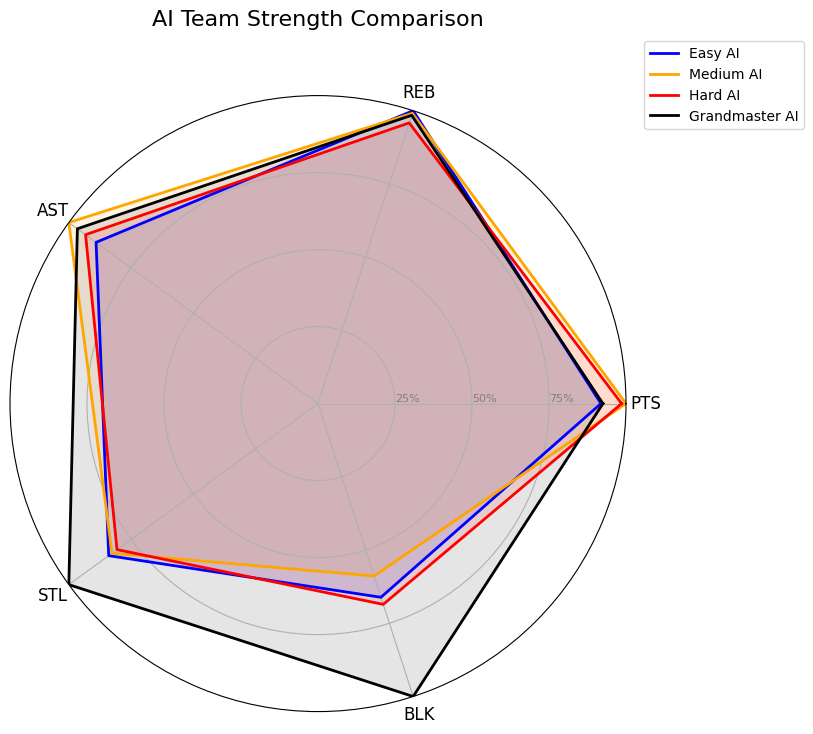

In [455]:
# 1. 定義計分規則 (因為 compute_fantasy_score 會用到)
rules = {
    "pts": 1, 
    "reb": 1.2, 
    "ast": 1.5, 
    "stl": 3, 
    "blk": 3, 
    "tov": 1 
}

print("========== 啟動 AI 選秀模擬系統 ==========")

# 2. 讀取資料
print("1. 正在讀取資料...")
# 確保這裡呼叫的是我們修復過、會處理欄位改名的 load_and_prep_data
df = load_and_prep_data() 

# 3. 再次確認欄位名稱 (防呆機制)
# 如果 user 的資料還是舊的 gp_base，這裡幫忙手動改名
if 'gp' not in df.columns and 'gp_base' in df.columns:
    print("   ⚠️ 偵測到 gp_base，自動重新命名為 gp...")
    df = df.rename(columns={'gp_base': 'gp', 'age_base': 'age', 'min_base': 'min'})

# 4. 計算分數
df = compute_fantasy_score(df, rules)

# 5. 檢查位置欄位 (我們已經有真實位置，不需要隨機生成)
if 'position' in df.columns:
    print("   ✅ 成功讀取球員真實位置 (Position)")
else:
    print("   ❌ 警告：資料中缺少 position 欄位，AI 的位置限制功能將失效！")
    # 只有真的完全抓不到時，才給一個預設值，避免程式崩潰
    df['position'] = 'G-F' 

print("\n2. 初始化遊戲引擎與特徵工程...")
# 這裡會自動計算 durability_score
X, y = create_ml_features(df)

print("3. 訓練 AI 大腦 (RandomForest)...")
model = train_draft_model(X, y)

# 預先算好 pred_score 方便觀察 (包含耐戰度修正)
# 注意：這裡預測的是「全勤狀態下的分數」，AI 選人時會再自己乘上 durability
df['pred_score'] = model.predict(X)

print("\n 開始進化版 AI 實力測試 (各選 10 輪) ")

# 模擬選秀 (這裡會呼叫 ai_agent.py 裡的邏輯)
# 確保 simulate_ai_draft 裡面有正確傳入 current_team
team_easy = simulate_ai_draft("easy", df, model)
team_medium = simulate_ai_draft("medium", df, model)
team_hard = simulate_ai_draft("hard", df, model)
team_grandmaster = simulate_ai_draft("grandmaster", df, model)

# 6. 顯示結果表格
results = []
for name, team in [("Easy AI", team_easy), ("Medium AI", team_medium), ("Hard AI", team_hard), ("Grandmaster AI", team_grandmaster)]:
    # 統計位置分佈
    pos_counts = team['position'].value_counts().to_dict() if 'position' in team.columns else "N/A"
    
    stats = {
        "AI 難度": name,
        "總 Fantasy 分數": team['fantasy_score'].sum(),
        "平均出賽(GP)": team['gp'].mean(), # 觀察重點：Hard AI 應該要最高
        "總助攻 (AST)": team['ast'].sum(),
        "總抄截 (STL)": team['stl'].sum(), # 觀察重點：Hard AI 應該要較高
        "總火鍋 (BLK)": team['blk'].sum(),
        "位置分佈": str(pos_counts)        # 觀察重點：不應該是空的
    }
    results.append(stats)

results_df = pd.DataFrame(results)
display(results_df)

# 7. 詳細觀察 Hard AI
print("\n🔍 詳細觀察 Hard AI 的陣容：")
# 顯示欄位包含 gp 和 durability_score 以便驗證
if 'durability_score' in team_hard.columns:
    cols_to_show = ['player_name', 'position', 'gp', 'durability_score', 'ast', 'stl', 'blk']
else:
    cols_to_show = ['player_name', 'position', 'gp', 'ast', 'stl', 'blk']
    
print(team_hard[cols_to_show])

# 8. 畫圖
print("\n📊 繪製雷達圖...")
my_teams = {
    'Easy AI': team_easy, 
    'Medium AI': team_medium, 
    'Hard AI': team_hard,
    'Grandmaster AI': team_grandmaster
}
# 呼叫我們剛剛寫好的繪圖函式
plot_ai_radar_chart(my_teams)

In [456]:
# --- Snake Draft ---
print("Select your difficulty: 1. Easy 2. Medium 3. Hard 4. Grandmaster")
while True:
    num_diff = input("Enter class number (1/2/3/4): ")
    if num_diff in ["1", "2", "3", "4"]:
        break
    else:
        print("Invalid choice. Please enter 1, 2, 3, or 4.")
        
if num_diff == "1":
    diff = "easy"
elif num_diff == "2":
    diff = "medium"
elif num_diff == "3":
    diff = "hard"
elif num_diff == "4":
    diff = "grandmaster"

my_team, ai_team = draft_snake_interactive(df, model, difficulty=diff)
print("Simualte Match: Player vs AI")
simulate_match_with_variance(my_team, ai_team, match_count=10)
print("\nSimualte Match: Player vs AI")
simulate_match_with_variance(my_team, ai_team, match_count=10)
print("\nSimualte Match: Player vs AI")
simulate_match_with_variance(my_team, ai_team, match_count=10)
print("\nSimualte Match: Player vs AI")
simulate_match_with_variance(my_team, ai_team, match_count=10)
print("\nSimualte Match: Player vs AI")
simulate_match_with_variance(my_team, ai_team, match_count=10)

Select your difficulty: 1. Easy 2. Medium 3. Hard 4. Grandmaster
========== 🐍 Fantasy Snake Draft 開始 (對手難度: grandmaster) ==========

--- Round 1 ---

可選球員 Top 20：
423. Nikola Jokić (DEN) - score=58.2
180. Giannis Antetokounmpo (MIL) - score=55.8
550. Victor Wembanyama (SAS) - score=52.1
490. Shai Gilgeous-Alexander (OKC) - score=51.3
28. Anthony Davis (DAL) - score=51.1
366. Luka Dončić (LAL) - score=50.5
314. Karl-Anthony Towns (NYK) - score=48.6
263. Jayson Tatum (BOS) - score=47.9
358. LeBron James (LAL) - score=46.7
69. Cade Cunningham (DET) - score=46.5
29. Anthony Edwards (MIN) - score=45.4
567. Zion Williamson (NOP) - score=44.7
443. Paolo Banchero (ORL) - score=44.4
330. Kevin Durant (PHX) - score=44.4
146. Domantas Sabonis (SAC) - score=43.1
241. James Harden (LAC) - score=43.1
353. LaMelo Ball (CHA) - score=43.1
545. Tyrese Maxey (PHI) - score=43.1
523. Trae Young (ATL) - score=43.0
230. Jalen Johnson (ATL) - score=42.5

💡 [AI 顧問建議]: 推薦選擇 **Shai Gilgeous-Alexander**
   👉 理由: 

'AI'

In [457]:
# AI vs AI
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm

# ==========================================
# 1. 定義靜音版自動選秀 (無 print/input)
# ==========================================
def auto_snake_draft(df, model, diff_p1, diff_p2):
    """
    自動化 Snake Draft
    diff_p1: 先選者的難度 (字串)
    diff_p2: 後選者的難度 (字串)
    """
    available = df.copy()
    p1_team_ids = []
    p2_team_ids = []
    
    # 建立難度對應函式
    ai_map = {
        'easy': ai_pick_easy,
        'medium': ai_pick_medium,
        'hard': ai_pick_hard,
        'grandmaster': ai_pick_grandmaster
    }
    
    # 5 輪 * 2 人 * 2 次(Snake) = 20 picks
    ROUNDS = 5
    
    for r in range(ROUNDS):
        # --- 1. P1 先選 ---
        curr_p1_team = df.loc[p1_team_ids] if p1_team_ids else pd.DataFrame(columns=df.columns)
        pick1 = ai_map[diff_p1](available, model, curr_p1_team)
        p1_team_ids.append(pick1)
        available = available.drop(pick1)
        
        # --- 2. P2 選 ---
        curr_p2_team = df.loc[p2_team_ids] if p2_team_ids else pd.DataFrame(columns=df.columns)
        pick2 = ai_map[diff_p2](available, model, curr_p2_team)
        p2_team_ids.append(pick2)
        available = available.drop(pick2)
        
        # --- 3. P2 Snake (再選) ---
        curr_p2_team = df.loc[p2_team_ids] 
        pick3 = ai_map[diff_p2](available, model, curr_p2_team)
        p2_team_ids.append(pick3)
        available = available.drop(pick3)
        
        # --- 4. P1 Snake (再選) ---
        curr_p1_team = df.loc[p1_team_ids]
        pick4 = ai_map[diff_p1](available, model, curr_p1_team)
        p1_team_ids.append(pick4)
        available = available.drop(pick4)
        
    return df.loc[p1_team_ids], df.loc[p2_team_ids]

# ==========================================
# 2. 定義靜音版比賽模擬 (無 print)
# ==========================================
def simulate_match_silent(team1_df, team2_df):
    """
    回傳: 1 (Team1贏), -1 (Team2贏), 0 (平手)
    """
    categories = ['pts', 'reb', 'ast', 'stl', 'blk', 'tov']
    variance_map = {'pts': 0.25, 'reb': 0.25, 'ast': 0.3, 'stl': 0.5, 'blk': 0.5, 'tov': 0.4}
    
    t1_wins = 0
    t2_wins = 0
    
    t1_totals = {cat: 0.0 for cat in categories}
    t2_totals = {cat: 0.0 for cat in categories}
    
    # 模擬單場波動表現
    for _, player in team1_df.iterrows():
        for cat in categories:
            t1_totals[cat] += get_game_performance(player[cat], variance_map[cat])
            
    for _, player in team2_df.iterrows():
        for cat in categories:
            t2_totals[cat] += get_game_performance(player[cat], variance_map[cat])
            
    # 結算
    for cat in categories:
        s1 = t1_totals[cat]
        s2 = t2_totals[cat]
        
        if cat == 'tov':
            if s1 < s2: t1_wins += 1
            else: t2_wins += 1
        else:
            if s1 > s2: t1_wins += 1
            else: t2_wins += 1
            
    if t1_wins > t2_wins: return 1
    elif t2_wins > t1_wins: return -1
    else: return 0

# ==========================================
# 3. 執行大規模模擬 (Monte Carlo)
# ==========================================

difficulties = ['easy', 'medium', 'hard', 'grandmaster']
simulation_results = []

# 產生所有排列組合 (4 * 4 = 16種)
combinations = list(itertools.product(difficulties, difficulties))

SIMULATION_COUNT = 100 # 每個組合跑 100 次

print(f"🚀 開始執行大規模模擬：共 {len(combinations)} 種組合，每組 {SIMULATION_COUNT} 場...")

# 使用 tqdm 顯示進度條 (如果沒裝 tqdm，可以把 range 改成一般的)
for p1_diff, p2_diff in tqdm(combinations):
    
    p1_wins = 0
    p2_wins = 0
    ties = 0
    
    for _ in range(SIMULATION_COUNT):
        # 1. 選秀
        t1, t2 = auto_snake_draft(df, model, p1_diff, p2_diff)
        
        # 2. 比賽
        result = simulate_match_silent(t1, t2)
        
        if result == 1: p1_wins += 1
        elif result == -1: p2_wins += 1
        else: ties += 1
        
    # 記錄結果
    simulation_results.append({
        "P1 (先選)": p1_diff,
        "P2 (後選)": p2_diff,
        "P1 勝場": p1_wins,
        "P2 勝場": p2_wins,
        "平手": ties,
        "P1 勝率": f"{p1_wins / SIMULATION_COUNT * 100:.1f}%"
    })

# ==========================================
# 4. 顯示結果與分析
# ==========================================
results_df = pd.DataFrame(simulation_results)

print("\n📊 大規模模擬結果列表：")
display(results_df)

# --- 進階分析：哪個 AI 最強？ ---
# 計算每個難度當 P1 或 P2 時的總勝率
print("\n🏆 AI 強度總排名 (平均勝率)：")
ai_performance = {}

for diff in difficulties:
    # 當 P1 的勝場
    wins_as_p1 = results_df[results_df["P1 (先選)"] == diff]["P1 勝場"].sum()
    # 當 P2 的勝場
    wins_as_p2 = results_df[results_df["P2 (後選)"] == diff]["P2 勝場"].sum()
    
    total_games = SIMULATION_COUNT * 2 * 4 # 總共參與的場次 (4個對手 * 2個位置)
    total_wins = wins_as_p1 + wins_as_p2
    
    ai_performance[diff] = total_wins / total_games

# 轉成 DataFrame 顯示
rank_df = pd.DataFrame(list(ai_performance.items()), columns=['AI 難度', '總勝率'])
rank_df = rank_df.sort_values('總勝率', ascending=False).reset_index(drop=True)
rank_df['總勝率'] = rank_df['總勝率'].apply(lambda x: f"{x*100:.1f}%")
display(rank_df)

🚀 開始執行大規模模擬：共 16 種組合，每組 100 場...


100%|██████████| 16/16 [04:08<00:00, 15.54s/it]


📊 大規模模擬結果列表：


,P1 (先選),P2 (後選),P1 勝場,P2 勝場,平手,P1 勝率
0,easy,easy,41,33,26,41.0%
1,easy,medium,14,60,26,14.0%
2,easy,hard,14,52,34,14.0%
3,easy,grandmaster,2,81,17,2.0%
4,medium,easy,64,11,25,64.0%
5,medium,medium,22,30,48,22.0%
6,medium,hard,58,13,29,58.0%
7,medium,grandmaster,5,82,13,5.0%
8,hard,easy,52,14,34,52.0%
9,hard,medium,28,25,47,28.0%



🏆 AI 強度總排名 (平均勝率)：


,AI 難度,總勝率
0,grandmaster,68.6%
1,medium,33.4%
2,hard,29.1%
3,easy,16.5%


In [458]:
# AI vs AI vs AI vs AI
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm

# ==========================================
# 1. 多人版自動選秀 (支援 N 人)
# ==========================================
def auto_league_draft(df, model, ai_diff_list):
    """
    ai_diff_list: 難度列表，例如 ['grandmaster', 'medium', 'hard', 'easy']
    代表 P1 到 P4 的 AI 難度
    """
    num_players = len(ai_diff_list)
    available = df.copy()
    
    # 初始化每個隊伍的名單
    teams_map = {i: [] for i in range(num_players)} # {0: [], 1: []...}
    
    # AI 映射
    ai_map = {
        'easy': ai_pick_easy,
        'medium': ai_pick_medium,
        'hard': ai_pick_hard,
        'grandmaster': ai_pick_grandmaster
    }
    
    ROUNDS = 5 # 每隊選 5 人 (模擬先發) 或 8 人
    
    for r in range(ROUNDS):
        # 決定這一輪的順序 (Snake)
        # 偶數輪 (0, 2...): 0 -> 1 -> 2 -> 3
        # 奇數輪 (1, 3...): 3 -> 2 -> 1 -> 0
        if r % 2 == 0:
            order = range(num_players)
        else:
            order = range(num_players - 1, -1, -1)
            
        for player_idx in order:
            diff = ai_diff_list[player_idx]
            
            # 建立目前隊伍 DataFrame
            current_ids = teams_map[player_idx]
            curr_team_df = df.loc[current_ids] if current_ids else pd.DataFrame(columns=df.columns)
            
            # AI 選人
            pick = ai_map[diff](available, model, curr_team_df)
            
            teams_map[player_idx].append(pick)
            available = available.drop(pick)
            
    # 回傳所有隊伍的 DataFrame 列表
    return [df.loc[teams_map[i]] for i in range(num_players)]

# ==========================================
# 2. 多人 Roto 積分計算 (Ranking System)
# ==========================================
def calculate_roto_standings(teams_list):
    """
    計算 Roto 積分：
    如果有 4 隊，每一項數據第一名得 4 分，最後一名得 1 分。
    最後加總所有項目積分。
    """
    categories = ['pts', 'reb', 'ast', 'stl', 'blk', 'tov']
    # 波動設定
    variance_map = {'pts': 0.25, 'reb': 0.25, 'ast': 0.3, 'stl': 0.5, 'blk': 0.5, 'tov': 0.4}
    
    num_teams = len(teams_list)
    
    # 1. 模擬數據表現 (加入波動)
    team_stats = []
    for team_df in teams_list:
        stats = {cat: 0.0 for cat in categories}
        for _, player in team_df.iterrows():
            for cat in categories:
                stats[cat] += get_game_performance(player[cat], variance_map[cat])
        team_stats.append(stats)
        
    # 2. 計算 Roto 積分
    roto_scores = [0] * num_teams
    
    for cat in categories:
        # 取出該項目所有隊伍的數值
        values = [t[cat] for t in team_stats]
        
        # 排序 (回傳索引)
        # argsort 排出來是從小到大 (0...N)
        sorted_indices = np.argsort(values)
        
        # 給分
        for rank, team_idx in enumerate(sorted_indices):
            # rank 0 是最小值 (第1名或最後一名)
            points = rank + 1
            
            if cat == 'tov':
                # 失誤越少(rank小)分數越高 -> 反過來給分
                # 這裡原本 argsort 是從小到大，失誤小排前面，所以 points = (num_teams - rank)
                actual_points = num_teams - rank
            else:
                # 其他數據越高(rank大)分數越高
                actual_points = points
                
            roto_scores[team_idx] += actual_points
            
    # 回傳分數列表 [P1分數, P2分數, P3分數, P4分數]
    return roto_scores

# ==========================================
# 3. 執行 4 人局模擬
# ==========================================

# 設定 4 個 AI，假設都是 Grandmaster (測試先手優勢)
# 或者你可以改成 ['grandmaster', 'medium', 'hard', 'easy'] 來大亂鬥
lineup_config = ['grandmaster', 'grandmaster', 'grandmaster', 'grandmaster']

SIM_COUNT = 100
total_roto_points = [0] * 4
wins = [0] * 4 # 紀錄誰拿第一名

print(f"🚀 開始執行 4 人局 Snake Draft 模擬 (同難度測試位置優勢)...")

for _ in tqdm(range(SIM_COUNT)):
    # 1. 選秀
    teams = auto_league_draft(df, model, lineup_config)
    
    # 2. 結算
    scores = calculate_roto_standings(teams)
    
    # 3. 累計
    for i in range(4):
        total_roto_points[i] += scores[i]
        
    # 判斷冠軍
    winner_idx = np.argmax(scores)
    wins[winner_idx] += 1

# ==========================================
# 4. 分析結果
# ==========================================
print("\n📊 4 人局位置優勢分析 (全部使用 Grandmaster AI):")
print(f"{'順位':<10} | {'平均 Roto 分':<15} | {'奪冠次數':<10} | {'勝率'}")
print("-" * 50)

for i in range(4):
    avg_score = total_roto_points[i] / SIM_COUNT
    win_rate = wins[i] / SIM_COUNT
    print(f"Pick #{i+1:<4} | {avg_score:<15.1f} | {wins[i]:<10} | {win_rate:.1%}")

🚀 開始執行 4 人局 Snake Draft 模擬 (同難度測試位置優勢)...


100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


📊 4 人局位置優勢分析 (全部使用 Grandmaster AI):
順位         | 平均 Roto 分       | 奪冠次數       | 勝率
--------------------------------------------------
Pick #1    | 16.2            | 48         | 48.0%
Pick #2    | 14.5            | 18         | 18.0%
Pick #3    | 14.9            | 21         | 21.0%
Pick #4    | 14.4            | 13         | 13.0%
